In [6]:
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
from itertools import product, islice
import re
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from nupack import *
import random
# Define the model
model1 = Model(material='dna', ensemble='stacking', celsius=16, sodium=1, magnesium=0.00)

In [7]:
class ComplexNotFound(Exception):
    """Exception when a complex is not found."""
    pass

def get_complex_concentration(complexes, s1_index, s2_index):
    """Retrieve concentration, trying both orderings."""
    complex_name_1 = f's{s1_index}+s{s2_index}'
    complex_name_2 = f's{s2_index}+s{s1_index}'
    
    for complex_key, concentration in complexes.items():
        if complex_key.name in [f'({complex_name_1})', f'({complex_name_2})']:
            return concentration, complex_key.name.strip('()')
    
    raise ComplexNotFound(f"Complex '{complex_name_1}' or '{complex_name_2}' not found.")

In [21]:
# Initialize strands from sequences, make sure forward + reverse order
sequences = """
TAGCACGTA
TACGTGCTA
TACGCACTA
TAGTGCGTA
TATCTCGCA
TGCGAGATA
TATCGAGCA
TGCTCGATA
TATGCGGTA
TACCGCATA
TAACGGCTA
TAGCCGTTA
TACGCCATA
TATGGCGTA
TGTGGTGTA
TACACCACA
""".split()

strands = [Strand(seq, name=f's{i+1}') for i, seq in enumerate(sequences)]
tube_all = Tube({strand: 10e-9 for strand in strands}, SetSpec(max_size=2), name='all_in_one')

# Perform complex analysis and concentration calculations
result_all = complex_analysis(complexes=tube_all.complexes, model=model1, compute=['pfunc'])
conc_results_all = complex_concentrations(tube=tube_all, data=result_all)
tube_result_all = conc_results_all.tubes[tube_all]

# Retrieve and organize concentration data for printing
complex_concentration_pairs_with_info = []
for i in range(0, len(sequences), 2):
    concentration, used_complex_name = get_complex_concentration(tube_result_all.complex_concentrations, i + 1, i + 2)
    concentration *= 1e9  # Convert to nM
    seq1, seq2 = sequences[i], sequences[i+1]
    complex_name = f's{i+1}+s{i+2}'
    complex_concentration_pairs_with_info.append((complex_name, f'{seq1} + {seq2}', concentration))

# Sort by concentration
sorted_concentrations = sorted(complex_concentration_pairs_with_info, key=lambda x: x[2], reverse=True)

# Print complex names and concentrations
print("Generated Complex Names:", [name for name, _, _ in sorted_concentrations])
for complex_id, names, concentration in sorted_concentrations:
    print(f"{complex_id} ({names}) is {concentration:.2f} nM")

# Print all sequences sorted by concentration
print("\nSequence Pairs From High to Low Concentration")
all_sequences_sorted = [seq for _, names, _ in sorted_concentrations for seq in names.split(' + ')]
for seq in all_sequences_sorted:
    print(seq)

# Print forward and reverse sequences
print("\nForward Sequences:")
for seq in all_sequences_sorted[::2]:
    print(seq)

print("\nReverse Sequences:")
for seq in all_sequences_sorted[1::2]:
    print(seq)

Generated Complex Names: ['s1+s2', 's3+s4', 's5+s6', 's7+s8', 's9+s10', 's11+s12', 's13+s14', 's15+s16']
s1+s2 (TAGCACGTA + TACGTGCTA) is 9.70 nM
s3+s4 (TACGCACTA + TAGTGCGTA) is 9.70 nM
s5+s6 (TATCTCGCA + TGCGAGATA) is 9.67 nM
s7+s8 (TATCGAGCA + TGCTCGATA) is 9.66 nM
s9+s10 (TATGCGGTA + TACCGCATA) is 9.63 nM
s11+s12 (TAACGGCTA + TAGCCGTTA) is 9.63 nM
s13+s14 (TACGCCATA + TATGGCGTA) is 9.63 nM
s15+s16 (TGTGGTGTA + TACACCACA) is 9.61 nM

Sequence Pairs From High to Low Concentration
TAGCACGTA
TACGTGCTA
TACGCACTA
TAGTGCGTA
TATCTCGCA
TGCGAGATA
TATCGAGCA
TGCTCGATA
TATGCGGTA
TACCGCATA
TAACGGCTA
TAGCCGTTA
TACGCCATA
TATGGCGTA
TGTGGTGTA
TACACCACA

Forward Sequences:
TAGCACGTA
TACGCACTA
TATCTCGCA
TATCGAGCA
TATGCGGTA
TAACGGCTA
TACGCCATA
TGTGGTGTA

Reverse Sequences:
TACGTGCTA
TAGTGCGTA
TGCGAGATA
TGCTCGATA
TACCGCATA
TAGCCGTTA
TATGGCGTA
TACACCACA


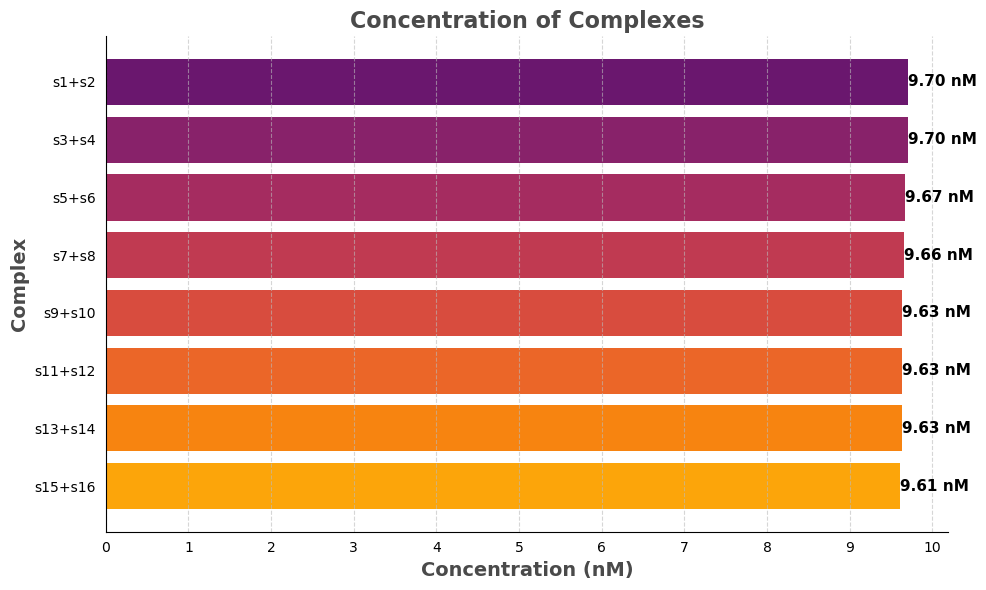

In [22]:
plt.figure(figsize=(10, 6))
n = len(sorted_concentrations)
colors = plt.cm.inferno(np.linspace(0.3, 0.8, n))
bars = plt.barh([complex_id for complex_id, _, _ in sorted_concentrations],
                [concentration for _, _, concentration in sorted_concentrations],
                color=colors)

plt.xlabel('Concentration (nM)', fontsize=14, fontweight='bold', color='#4A4A4A')
plt.ylabel('Complex', fontsize=14, fontweight='bold', color='#4A4A4A')
plt.title('Concentration of Complexes', fontsize=16, fontweight='bold', color='#4A4A4A')

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6, color='#BBBBBB')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, color='#4A4A4A')
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, color='#4A4A4A')

# Setting x-axis ticks to display whole numbers
max_concentration = max([concentration for _, _, concentration in sorted_concentrations])
plt.xticks(np.arange(0, max_concentration + 1, 1))  # Adjust step to 1 to include every integer

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f} nM', va='center', ha='left',
             color='black', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [23]:
# sequences = """
# TAACAGCCA 
# TGGCTGTTA
# TACAAGGCA
# TGCCTTGTA
# TACCAAGCA
# TGCTTGGTA
# ATCGTGCTA
# TAGCACGAT
# AGATGCGTA
# TACGCATCT
# AGCGATGTA
# TACATCGCT
# TAAGCCACA
# TGTGGCTTA
# """.split()

# calculate the free energy values for all sequences
table = []
for seq1 in sequences:
    row = []
    for seq2 in sequences:
        energy = pfunc([seq1, seq2], model=model1)[1]
        row.append(round(energy,2))
    table.append(row)

# create a pandas dataframe from the table
df = pd.DataFrame(table, index=sequences, columns=sequences)

# highlight the minimum value in each column
df.style.highlight_min(axis=0, color='green')

,TAGCACGTA,TACGTGCTA,TACGCACTA,TAGTGCGTA,TATCTCGCA,TGCGAGATA,TATCGAGCA,TGCTCGATA,TATGCGGTA,TACCGCATA,TAACGGCTA,TAGCCGTTA,TACGCCATA,TATGGCGTA,TGTGGTGTA,TACACCACA
TAGCACGTA,-9.490000,-17.140000,-9.830000,-10.060000,-7.640000,-8.050000,-9.620000,-8.910000,-7.940000,-8.190000,-11.400000,-7.980000,-9.040000,-8.300000,-9.480000,-6.550000
TACGTGCTA,-17.140000,-10.640000,-10.580000,-9.380000,-7.810000,-7.850000,-8.940000,-10.600000,-8.190000,-7.920000,-8.710000,-11.580000,-8.850000,-9.050000,-6.500000,-8.170000
TACGCACTA,-9.830000,-10.580000,-7.560000,-17.140000,-7.400000,-10.930000,-7.800000,-7.870000,-11.170000,-7.430000,-7.660000,-9.350000,-7.310000,-11.960000,-9.450000,-5.020000
TAGTGCGTA,-10.060000,-9.380000,-17.140000,-7.210000,-10.260000,-7.420000,-7.680000,-7.520000,-7.230000,-10.590000,-9.200000,-7.100000,-11.590000,-7.180000,-4.890000,-9.310000
TATCTCGCA,-7.640000,-7.810000,-7.400000,-10.260000,-7.320000,-16.810000,-9.660000,-9.580000,-10.610000,-7.420000,-7.430000,-7.350000,-7.370000,-9.860000,-6.050000,-5.030000
TGCGAGATA,-8.050000,-7.850000,-10.930000,-7.420000,-16.810000,-7.680000,-9.970000,-11.100000,-7.790000,-10.710000,-8.030000,-7.370000,-10.130000,-7.770000,-4.940000,-6.370000
TATCGAGCA,-9.620000,-8.940000,-7.800000,-7.680000,-9.660000,-9.970000,-9.350000,-16.810000,-7.960000,-7.670000,-8.570000,-8.720000,-7.580000,-7.790000,-6.500000,-5.840000
TGCTCGATA,-8.910000,-10.600000,-7.870000,-7.520000,-9.580000,-11.100000,-16.810000,-8.820000,-7.560000,-7.910000,-9.080000,-8.140000,-7.690000,-7.440000,-5.550000,-5.940000
TATGCGGTA,-7.940000,-8.190000,-11.170000,-7.230000,-10.610000,-7.790000,-7.960000,-7.560000,-7.320000,-17.060000,-9.300000,-9.340000,-10.380000,-7.240000,-4.960000,-8.190000
TACCGCATA,-8.190000,-7.920000,-7.430000,-10.590000,-7.420000,-10.710000,-7.670000,-7.910000,-17.060000,-7.390000,-9.380000,-7.970000,-7.100000,-10.180000,-8.190000,-5.060000


In [ ]:
#  taking from tetrastacks

sequences = """
ACACACTCA
TGAGTGTGT
ACCAGAACA
TGTTCTGGT
ACCTCAACA
TGTTGAGGT
AGATGCGTA
TACGCATCT
AGCGATGTA
TACATCGCT
ATCGTGCTA
TAGCACGAT
ATTCGCCTA
TAGGCGAAT
TAACAGCCA
TGGCTGTTA
TAAGCCACA
TGTGGCTTA
TACAAGGCA
TGCCTTGTA
TACCAAGCA
TGCTTGGTA
TAGGTTGCA
TGCAACCTA
""".split()